In [95]:
# Jax Control Flow: 

import timeit

import jax.debug
from jax import jit
from jax import lax
from numba import njit

vel = 1.0
accl = 4.0
v_switch = 1.0
a_max = 5.0
v_min = 0.5
v_max = 20.0

@jit 
def jax_accl_constraints(vel, accl, v_switch, a_max, v_min, v_max):
    pos_limit = lax.cond(vel > v_switch, lambda _: a_max * v_switch / vel, lambda _: a_max, vel)
    accl_limit = lax.cond(
        lax.bitwise_and(vel <= v_min, vel <= 0) | lax.bitwise_and(vel >= v_max, vel >= 0),
        lambda _: 0.,
        lambda _: lax.cond(
            vel <= v_min,
            lambda _: lax.cond(accl <= -a_max, lambda _: -a_max, lambda _: pos_limit, accl),
            lambda _: lax.cond(accl >= pos_limit, lambda _: pos_limit, lambda _: accl, accl),
            vel
        ),
        vel
    )
    return accl_limit

def multiple_calls_jax(vel, accl, v_switch, a_max, v_min, v_max):  
    for i in range(1, 1000):
        vel = i/100
        accl_limit = jax_accl_constraints(vel, accl, v_switch, a_max, v_min, v_max)
    return accl_limit



callable_object = lambda: multiple_calls_jax(vel, accl, v_switch, a_max, v_min, v_max)
time = timeit.timeit(callable_object, number=10)
print(f"Time of jax.jit() function: {time}")
time = timeit.timeit(callable_object, number=10)
print(f"Time of jax.jit() function: {time}")
time = timeit.timeit(callable_object, number=10)
print(f"Time of jax.jit() function: {time}")
    
    
@njit  
def accl_constraints(vel, accl, v_switch, a_max, v_min, v_max):
    # positive accl limit
    if vel > v_switch:
        pos_limit = a_max * v_switch / vel
    else:
        pos_limit = a_max

    # accl limit reached?
    if (vel <= v_min and accl <= 0) or (vel >= v_max and accl >= 0):
        accl = 0.
    elif accl <= -a_max:
        accl = -a_max
    elif accl >= pos_limit:
        accl = pos_limit

    return accl


def multiple_calls(vel, accl, v_switch, a_max, v_min, v_max):  
    for i in range(1, 1000):
        vel = i/100
        accl_limit = accl_constraints(vel, accl, v_switch, a_max, v_min, v_max)
    return accl_limit

callable_object = lambda: multiple_calls(vel, accl, v_switch, a_max, v_min, v_max)
time = timeit.timeit(callable_object, number=10)
print(f"Time of original function: {time}")
time = timeit.timeit(callable_object, number=10)
print(f"Time of original function: {time}")
time = timeit.timeit(callable_object, number=10)
print(f"Time of original function: {time}")

Time of jax.jit() function: 2.2608833299964317
Time of jax.jit() function: 0.931571706001705
Time of jax.jit() function: 0.8627951279995614
Time of original function: 0.4391271320018859
Time of original function: 0.007307577001483878
Time of original function: 0.006754857997293584


In [10]:
import timeit
from jax import jit
from jax import lax
from numba import njit

steering_angle = 8.0
steering_velocity = 1.0 
s_min = 5.0 
s_max = 10.0 
sv_min = 2.0
sv_max = 8.0 

@jit
def steering_constraint(steering_angle, steering_velocity, s_min, s_max, sv_min, sv_max):
    """Steering constraints, adjusts the steering velocity based on constraints.

    Args:
        steering_angle (float): current steering_angle of the vehicle
        steering_velocity (float): unconstraint desired steering_velocity
        s_min (float): minimum steering angle
        s_max (float): maximum steering angle
        sv_min (float): minimum steering velocity
        sv_max (float): maximum steering velocity

    Returns:
        steering_velocity (float): adjusted steering velocity
    """

    # constraint steering velocity

    steering_velocity = lax.cond(
        (steering_angle <= s_min) | (steering_angle >= s_max),
        lambda _: 0.,
        lambda _: lax.cond(
            steering_velocity <= sv_min,
            lambda _: lax.cond(steering_velocity <= sv_min, lambda _: sv_min, lambda _: steering_velocity, steering_velocity),
            lambda _: lax.cond(steering_velocity >= sv_max, lambda _: sv_max, lambda _: steering_velocity, steering_velocity),
            steering_velocity
        ),
        steering_angle
    )
    return steering_velocity


@njit(cache=True)
def old_steering_constraint(steering_angle, steering_velocity, s_min, s_max, sv_min, sv_max):
    """Steering constraints, adjusts the steering velocity based on constraints.

    Args:
        steering_angle (float): current steering_angle of the vehicle
        steering_velocity (float): unconstraint desired steering_velocity
        s_min (float): minimum steering angle
        s_max (float): maximum steering angle
        sv_min (float): minimum steering velocity
        sv_max (float): maximum steering velocity

    Returns:
        steering_velocity (float): adjusted steering velocity
    """

    # constraint steering velocity
    if (steering_angle <= s_min and steering_velocity <= 0) or (steering_angle >= s_max and steering_velocity >= 0):
        steering_velocity = 0.
    elif steering_velocity <= sv_min:
        steering_velocity = sv_min
    elif steering_velocity >= sv_max:
        steering_velocity = sv_max

    return steering_velocity

jax_result = steering_constraint(steering_angle, steering_velocity, s_min, s_max, sv_min, sv_max)
old_result = old_steering_constraint(steering_angle, steering_velocity, s_min, s_max, sv_min, sv_max)
print(f"Jax Steering velocity: {jax_result}")
print(f"Old Steering velocity: {old_result}")



Jax Steering velocity: 2.0
Old Steering velocity: 2.0


In [3]:
from jax import lax
import jax.numpy as jnp 

a = jnp.array([1, 2, 3, 5, 7, 11, 13, 17])

result = []
res = 0
for i in a: 
    res += i
    result.append(res)
    
print(f"for loop: {jnp.array(result)}")

cumsum = jnp.cumsum(a)
print(f"Numpy implementation: {cumsum}")


from jax import lax 

def cumsum(res, el):
    res = res + el
    return res, res #carryover and accumulated

result_init = 0
final, result = lax.scan(cumsum, result_init, a)
print(f"Jax.lax.scan implementation: {result}")

for loop: [ 1  3  6 11 18 29 42 59]
Numpy implementation: [ 1  3  6 11 18 29 42 59]


NameError: name 'jax' is not defined

for loop: [100.       101.       102.01     103.0301   104.0604   105.101006]
[257.35376 259.9273  262.52655 265.15182 267.80334]
lax.scan: [100.       101.       102.01     103.0301   104.060394 105.101   ]
[244.86299 247.31161 249.78473 252.28258 254.8054  257.35345 259.92697
 262.52625 265.15152 267.80304]
100 100


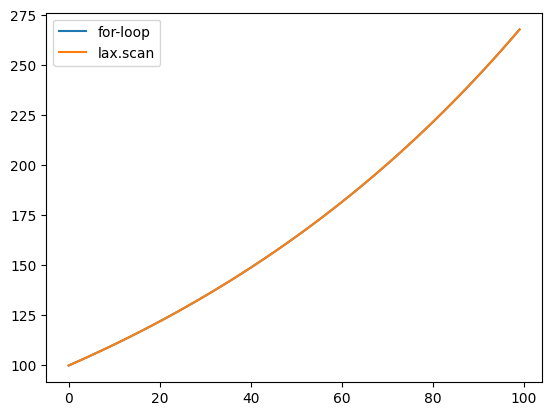

In [24]:
from functools import partial 
from jax import lax 
import jax.numpy as jnp 

wealth_record = []
starting_wealth = 100.0
interest_factor = 1.01
num_timesteps = 100
prev_wealth = starting_wealth

for t in range(num_timesteps):
    new_wealth = prev_wealth * interest_factor
    wealth_record.append(prev_wealth)
    prev_wealth = new_wealth

wealth_record = jnp.array(wealth_record)

def wealth_at_time(prev_wealth, time, interest_factor):
    new_wealth = prev_wealth * interest_factor
    return new_wealth, prev_wealth

wealth_func = partial(wealth_at_time, interest_factor=interest_factor)
timesteps = jnp.arange(num_timesteps)
final, result = lax.scan(wealth_func, init=starting_wealth, xs=timesteps)

import matplotlib.pyplot as plt


print(f"for loop: {wealth_record[:6]}")
print(wealth_record[95:])
print(f"lax.scan: {result[:6]}")
print(result[90:])
l1 = len(wealth_record)
l2 = len(result)
print(l1, l2)

plt.plot(wealth_record, label="for-loop")
plt.plot(result, label="lax.scan")
plt.legend();

In [ ]:
import jax.numpy as np
from jax import lax 
# NumPy equivalent

num_breaks = 30
breaking_fraction = 0.1

sticks = []
stick_length = 1.0
for i in range(num_breaks):
    stick = stick_length * breaking_fraction
    sticks.append(stick)
    stick_length = stick_length - stick
sticks = np.array(sticks)
print(sticks)

def stickbreak(num_breaks: int, frac: float):
    



sticks = scan(stickbreak)


In [7]:
import jax.numpy as np
from jax import lax

def xy_2_rc(x, y, orig_x, orig_y, orig_c, orig_s, height, width, resolution):
    """
    Translate (x, y) coordinate into (r, c) in the matrix.

    Args:
        x (float): coordinate in x (m)
        y (float): coordinate in y (m)
        orig_x (float): x coordinate of the map origin (m)
        orig_y (float): y coordinate of the map origin (m)

    Returns:
        r (int): row number in the transform matrix of the given point
        c (int): column number in the transform matrix of the given point
    """

    # translation
    x_trans = x - orig_x
    y_trans = y - orig_y

    # rotation
    x_rot = x_trans * orig_c + y_trans * orig_s
    y_rot = -x_trans * orig_s + y_trans * orig_c

    # clip the state to be a cell
    def true_fun(x_rot, y_rot, resolution):
        c = -1
        r = -1
        return c, r

    def false_fun(x_rot, y_rot, resolution):
        c = (x_rot / resolution).astype(int)
        r = (y_rot / resolution).astype(int)
        return c, r


    c, r = lax.cond(
        x_rot < 0,
        lambda _: true_fun(x_rot, y_rot, resolution),
        lambda _: lax.cond(
            x_rot >= width * resolution,
            lambda _: true_fun(x_rot, y_rot, resolution),
            lambda _: lax.cond(
                y_rot < 0,
                lambda _: true_fun(x_rot, y_rot, resolution),
                lambda _: lax.cond(
                    y_rot >= height * resolution,
                    lambda _: true_fun(x_rot, y_rot, resolution),
                    lambda _: false_fun(x_rot, y_rot, resolution),
                    None
                ),
                None
            ),
            None
        ),
        None
    )

    return r, c

def distance_transform(x, y, orig_x, orig_y, orig_c, orig_s, height, width, resolution, dt):
    """Look up corresponding distance in the distance matrix.

    Args:
        x (float): x coordinate of the lookup point
        y (float): y coordinate of the lookup point
        orig_x (float): x coordinate of the map origin (m)
        orig_y (float): y coordinate of the map origin (m)

    Returns:
        distance (float): corresponding shortest distance to obstacle in meters
    """
    r, c = xy_2_rc(x, y, orig_x, orig_y, orig_c, orig_s, height, width, resolution)
    distance = dt[r, c]
    return distance

def loop_cond(loop_vars):
    dist_to_nearest, eps, total_dist, max_range = loop_vars
    return lax.bitwise_and(dist_to_nearest > eps, total_dist <= max_range)

def loop_body(loop_vars):
    dist_to_nearest, eps, total_dist, max_range = loop_vars
    # TODO: make sure that this doesn't cause the vars to be reset on each loop
    
    x = 0.0
    y = 0.0

    x += dist_to_nearest * orig_c
    y += dist_to_nearest * orig_s

    dist_to_nearest = distance_transform(x, y, orig_x, orig_y, orig_c, orig_s, height, width, resolution, dt)
    total_dist += dist_to_nearest
    return dist_to_nearest, eps, total_dist, max_range


orig_x = 1.0
orig_y = 1.0
orig_c = 1.0
orig_s = 1.0
height = 10
width = 10
resolution = 1.0
dt = 0.1
dist_to_nearest = 1.0
eps = 0.1
total_dist = 0.0
max_range = 10.0
x = 0.0
y = 0.0

loop_vars = (dist_to_nearest, eps, total_dist, max_range)
dist_to_nearest, eps, total_dist, max_range = lax.while_loop(loop_cond, loop_body, loop_vars)
print(total_dist)


TypeError: 'float' object is not subscriptable